<a href="https://colab.research.google.com/github/Aravindan98/Le-Mans-Thesis/blob/main/DGM_CIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Galerkin Network and parameter initialization

In [14]:
# SCRIPT FOR SOLVING THE FOKKER-PLANCK EQUATION FOR ORNSTEIN-UHLENBECK PROCESS 
# WITH RANDOM (NORMALLY DISTRIBUTED) STARTING VALUE (see p.54)

#%% import needed packages

%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

#%% Parameters

class LSTMLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, trans1 = "tanh", trans2 = "tanh"):
        '''
        Args:
            input_dim (int):       dimensionality of input data
            output_dim (int):      number of outputs for LSTM layers
            trans1, trans2 (str):  activation functions used inside the layer; 
                                   one of: "tanh" (default), "relu" or "sigmoid"
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of LSTMLayer)
        super(LSTMLayer, self).__init__()
        
        # add properties for layer including activation functions used inside the layer  
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        if trans1 == "tanh":
            self.trans1 = tf.nn.tanh
        elif trans1 == "relu":
            self.trans1 = tf.nn.relu
        elif trans1 == "sigmoid":
            self.trans1 = tf.nn.sigmoid
        
        if trans2 == "tanh":
            self.trans2 = tf.nn.tanh
        elif trans2 == "relu":
            self.trans2 = tf.nn.relu
        elif trans2 == "sigmoid":
            self.trans2 = tf.nn.relu
        
        ### define LSTM layer parameters (use Xavier initialization)
        # u vectors (weighting vectors for inputs original inputs x)
        self.Uz = self.add_variable("Uz", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Ug = self.add_variable("Ug", shape=[self.input_dim ,self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Ur = self.add_variable("Ur", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Uh = self.add_variable("Uh", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        
        # w vectors (weighting vectors for output of previous layer)        
        self.Wz = self.add_variable("Wz", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Wg = self.add_variable("Wg", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Wr = self.add_variable("Wr", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Wh = self.add_variable("Wh", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        
        # bias vectors
        self.bz = self.add_variable("bz", shape=[1, self.output_dim])
        self.bg = self.add_variable("bg", shape=[1, self.output_dim])
        self.br = self.add_variable("br", shape=[1, self.output_dim])
        self.bh = self.add_variable("bh", shape=[1, self.output_dim])
    
    
    # main function to be called 
    def call(self, S, X):
        '''Compute output of a LSTMLayer for a given inputs S,X .    

        Args:            
            S: output of previous layer
            X: data input
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''   
        
        # compute components of LSTM layer output (note H uses a separate activation function)
        Z = self.trans1(tf.add(tf.add(tf.matmul(X,self.Uz), tf.matmul(S,self.Wz)), self.bz))
        G = self.trans1(tf.add(tf.add(tf.matmul(X,self.Ug), tf.matmul(S, self.Wg)), self.bg))
        R = self.trans1(tf.add(tf.add(tf.matmul(X,self.Ur), tf.matmul(S, self.Wr)), self.br))
        
        H = self.trans2(tf.add(tf.add(tf.matmul(X,self.Uh), tf.matmul(tf.multiply(S, R), self.Wh)), self.bh))
        
        # compute LSTM layer output
        S_new = tf.add(tf.multiply(tf.subtract(tf.ones_like(G), G), H), tf.multiply(Z,S))
        
        return S_new

#%% Fully connected (dense) layer - modification of Keras layer class
   
class DenseLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, transformation=None):
        '''
        Args:
            input_dim:       dimensionality of input data
            output_dim:      number of outputs for dense layer
            transformation:  activation function used inside the layer; using
                             None is equivalent to the identity map 
        
        Returns: customized Keras (fully connected) layer object 
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of DenseLayer)
        super(DenseLayer,self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        ### define dense layer parameters (use Xavier initialization)
        # w vectors (weighting vectors for output of previous layer)
        self.W = self.add_variable("W", shape=[self.input_dim, self.output_dim], initializer = tf.contrib.layers.xavier_initializer())
        
        # bias vectors
        self.b = self.add_variable("b", shape=[1, self.output_dim])
        
        if transformation:
            if transformation == "tanh":
                self.transformation = tf.tanh
            elif transformation == "relu":
                self.transformation = tf.nn.relu
        else:
            self.transformation = transformation
    
    
    # main function to be called 
    def call(self,X):
        '''Compute output of a dense layer for a given input X 

        Args:                        
            X: input to layer            
        '''
        
        # compute dense layer output
        S = tf.add(tf.matmul(X, self.W), self.b)
                
        if self.transformation:
            S = self.transformation(S)
        
        return S

#%% Neural network architecture used in DGM - modification of Keras Model class
    
class DGMNet(tf.keras.Model):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, layer_width, n_layers, input_dim, final_trans=None):
        '''
        Args:
            layer_width: 
            n_layers:    number of intermediate LSTM layers
            input_dim:   spaital dimension of input data (EXCLUDES time dimension)
            final_trans: transformation used in final layer
        
        Returns: customized Keras model object representing DGM neural network
        '''  
        
        # create an instance of a Model object (call initialize function of superclass of DGMNet)
        super(DGMNet,self).__init__()
        
        # define initial layer as fully connected 
        # NOTE: to account for time inputs we use input_dim+1 as the input dimensionality
        self.initial_layer = DenseLayer(layer_width, input_dim+1, transformation = "tanh")
        
        # define intermediate LSTM layers
        self.n_layers = n_layers
        self.LSTMLayerList = []
                
        for _ in range(self.n_layers):
            self.LSTMLayerList.append(LSTMLayer(layer_width, input_dim+1))
        
        # define final layer as fully connected with a single output (function value)
        self.final_layer = DenseLayer(1, layer_width, transformation = final_trans)
    
    
    # main function to be called  
    def call(self,t,x):
        '''            
        Args:
            t: sampled time inputs 
            x: sampled space inputs

        Run the DGM model and obtain fitted function value at the inputs (t,x)                
        '''  
        
        # define input vector as time-space pairs
        X = tf.concat([t,x],1)
        
        # call initial layer
        S = self.initial_layer.call(X)
        
        # call intermediate LSTM layers
        for i in range(self.n_layers):
            S = self.LSTMLayerList[i].call(S,X)
        
        # call final LSTM layers
        result = self.final_layer.call(S)
        
        return result

In [17]:
# CIR process parameters 
kappa = 0.03  # mean reversion rate
theta = 0.03  # mean reversion level
sigma = 0.02    # volatility

# mean and standard deviation for (normally distributed) process starting value
x_t = 0.5
alpha = x_t
beta = 0.1



# terminal time 
T = 5.0

# bounds of sampling region for space dimension, i.e. sampling will be done on
# [multiplier*Xlow, multiplier*Xhigh]
Xlow = 0.1
Xhigh = 0.9
x_multiplier = 1.0
t_multiplier = 1.0

# neural network parameters
num_layers = 3
nodes_per_layer = 50
learning_rate = 0.001

# Training parameters
sampling_stages = 100    # number of times to resample new time-space domain points
steps_per_sample = 10    # number of SGD steps to take before re-sampling

# Sampling parameters
nSim_t = 5
nSim_x_interior = 50
nSim_x_initial = 50

# Save options
saveOutput = False
saveName   = 'FokkerPlanck'
saveFigure = False
figureName = 'fokkerPlanck_density.png'

## Cox-Ingersoll-Ross process: $dX_t=\kappa(\theta-X_t)dt+\sigma \sqrt{X_t}dW_t$
### $X_0 \sim N(x_0,\nu)$
Initial condition is approximating a Dirac Delta $\delta({x-x_0})$

In [5]:
#%% Sampling function - randomly sample time-space pairs 

def sampler(nSim_t, nSim_x_interior, nSim_x_initial):
    ''' Sample time-space points from the function's domain; points are sampled
        uniformly on the interior of the domain, at the initial/terminal time points
        and along the spatial boundary at different time points. 
    
    Args:
        nSim_t:          number of (interior) time points to sample
        nSim_x_interior: number of space points in the interior of the function's domain to sample 
        nSim_x_initial:  number of space points at initial time to sample (initial condition)
    ''' 
    
    # Sampler #1: domain interior
    t = np.random.uniform(low=0, high=T, size=[nSim_t, 1])
    x_interior = np.random.uniform(low=Xlow, high=Xhigh, size=[nSim_x_interior, 1])
    
    # Sampler #2: spatial boundary
        # no spatial boundary condition for this problem 
    
    # Sampler #3: initial/terminal condition
    x_initial = np.random.uniform(low=Xlow, high=Xhigh, size = [nSim_x_initial, 1])
    
    return t, x_interior, x_initial

### A transformation is applied to get a better approximation of the pdf

## $p(t,x)=\frac{e^{-u(t,x)}}{c(t)}$

$c(t)$ is basically a normalizing constant and we take it as $\int e^{-u(t,x)}dx$

## $$ p_t -\kappa p - (\kappa(x-\theta)+\sigma^2) p_x -(\frac{\sigma^2x}{2})p_{xx} = 0 $$

after transformation

## $$ -u_t + \psi -\kappa + (\kappa(x-\theta)+\sigma^2) u_x - (\frac{\sigma^2x}{2})(u_x^2-u_{xx}) = 0$$

## $\psi = \frac{\int u_te^{-u(x,t)}dx}{\int e^{-u(x,t)}dx}$

In [18]:
#%% Loss function for Fokker-Planck equation


def loss(model, t, x_interior, x_initial, nSim_t, alpha, beta, theta, sigma):
    ''' Compute total loss for training.
        NOTE: the loss is based on the PDE satisfied by the negative-exponential
              of the density and NOT the density itself, i.e. the u(t,x) in 
              p(t,x) = exp(-u(t,x)) / c(t)
              where p is the density and c is the normalization constant
    
    Args:
        model:      DGM model object
        t:          sampled (interior) time points
        x_interior: sampled space points in the interior of the function's domain
        x_initial:  sampled space points at initial time
        nSim_t:     number of (interior) time points sampled (size of t)
        alpha:      mean of normal distribution for process starting value
        beta:       standard deviation of normal distribution for process starting value
    ''' 
    
    # Loss term #1: PDE
    
    # initialize vector of losses
    losses_u = []
    
    # for each simulated interior time point
    for tIndex in range(nSim_t):
        
        # make vector of current time point to align with simulated interior space points   
        curr_t = t[tIndex]
        t_vector = curr_t * tf.ones_like(x_interior)
        
        # compute function value and derivatives at current sampled points
        u    = model(t_vector, x_interior)

        u_t  = tf.gradients(u, t_vector)[0]
        u_x  = tf.gradients(u, x_interior)[0]
        u_xx = tf.gradients(u_x, x_interior)[0]
        
        # psi function: normalized and exponentiated neural network
        # note: sums are used to approximate integrals (importance sampling)
        psi_denominator = tf.reduce_sum(tf.exp(-u))
        psi = tf.reduce_sum( u_t*tf.exp(-u) ) / psi_denominator

        # PDE differential operator
        diff_f = -u_t - kappa + (kappa*(x_interior- theta)+sigma**2)*u_x - ((0.5*sigma**2)*x_interior)*(-u_xx + u_x**2) + psi
        #diff_f = -u_t + kappa - kappa*(x_interior- theta)*u_x - 0.5*sigma**2*(-u_xx + u_x**2) + psi
        
        # compute L2-norm of differential operator and attach to vector of losses
        currLoss = tf.reduce_mean(tf.square(diff_f)) 
        losses_u.append(currLoss)
    
    # average losses across sample time points 
    L1 = tf.add_n(losses_u) / nSim_t
    
    # Loss term #2: boundary condition
        # no boundary condition for this problem
    
    # Loss term #3: initial condition
    
    # compute negative-exponential of neural network-implied pdf at t = 0
    # i.e. the u in p = e^[-u(t,x)] / c(t)
    fitted_pdf = model(0*tf.ones_like(x_initial), x_initial)
    
    # target pdf - normally distributed starting value
    # NOTE: we are only comparing the exponential terms 
    target_pdf  = 0.5*(x_initial - alpha)**2 / (beta**2)
    
    # average L2 error for initial distribution
    L3 = tf.reduce_mean(tf.square(fitted_pdf - target_pdf))

    return L1, L3 

In [19]:

#%% Set up network

# initialize DGM model (last input: space dimension = 1)
model = DGMNet(nodes_per_layer, num_layers, 1)

# tensor placeholders (_tnsr suffix indicates tensors)
# inputs (time, space domain interior, space domain at initial time)
t_tnsr = tf.placeholder(tf.float32, [None,1])
x_interior_tnsr = tf.placeholder(tf.float32, [None,1])
x_initial_tnsr = tf.placeholder(tf.float32, [None,1])

# loss 
L1_tnsr, L3_tnsr = loss(model, t_tnsr, x_interior_tnsr, x_initial_tnsr, nSim_t, alpha, beta, theta, sigma)
loss_tnsr = L1_tnsr + L3_tnsr

# UNNORMALIZED density 
u = model(t_tnsr, x_interior_tnsr)
p_unnorm = tf.exp(-u)

# set optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_tnsr)

# initialize variables
init_op = tf.global_variables_initializer()

# open session
sess = tf.Session()
sess.run(init_op)

#%% Train network
# for each sampling stage
for i in range(sampling_stages):
    
    # sample uniformly from the required regions
    t, x_interior, x_initial = sampler(nSim_t, nSim_x_interior, nSim_x_initial)
    
    # for a given sample, take the required number of SGD steps
    for j in range(steps_per_sample):
        loss,L1,L3,_ = sess.run([loss_tnsr, L1_tnsr, L3_tnsr, optimizer],
                                feed_dict = {t_tnsr:t, x_interior_tnsr:x_interior, x_initial_tnsr:x_initial})
        
    print(loss, L1, L3, i)

# save outout
saver = tf.train.Saver()
saver.save(sess, './SavedNets/' + saveName)

#%% Plot results

# LaTeX rendering for text in plots
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

# figure options


9.798627 0.0007605692 9.797866 0
6.4218554 0.0016630691 6.4201922 1
4.792348 0.0035848033 4.788763 2
4.7873235 0.010049708 4.7772737 3
2.4360397 0.087937616 2.348102 4
0.35988367 0.13120498 0.2286787 5
0.38141102 0.28012577 0.10128526 6
0.25956014 0.113128684 0.14643145 7
0.32271317 0.1701473 0.15256587 8
0.44091707 0.20117424 0.23974285 9
0.27386233 0.19003712 0.08382522 10
0.13440597 0.10246654 0.03193944 11
0.11911573 0.09772726 0.02138847 12
0.10556197 0.08131136 0.024250608 13
0.054650642 0.026899476 0.027751166 14
0.07802236 0.05297577 0.025046587 15
0.03738797 0.023514817 0.013873155 16
0.030713532 0.02668265 0.0040308824 17
0.0447619 0.034286205 0.010475695 18
0.02176034 0.013867684 0.007892658 19
0.019523077 0.012338924 0.0071841534 20
0.012186177 0.0072543435 0.004931834 21
0.020072307 0.014433351 0.005638957 22
0.011422006 0.0066942126 0.004727794 23
0.0070863944 0.00078032253 0.0063060718 24
0.006884571 0.0037096646 0.0031749064 25
0.016334847 0.012191107 0.0041437405 26
0.

'./SavedNets/FokkerPlanck'

In [39]:
#%% OU Simulation function
def simulateCIR_GaussianStart(alpha, beta, theta, kappa, sigma, nSim, T):
    ''' Simulate end point of Ornstein-Uhlenbeck process with normally 
        distributed random starting value.
    
    Args:
        alpha: mean of random starting value
        beta:  standard deviation of random starting value
        theta: mean reversion level
        kappa: mean reversion rate
        sigma: volatility 
        nSim:  number of simulations
        T:     terminal time        
    '''  
        
    # simulate initial point based on normal distribution
    X0 = np.random.normal(loc = alpha, scale = beta, size = nSim)
    
    # degrees of freedom (k) and non-centrality parameteer (lambda)
    
    c = (2*kappa)/((1-np.exp(-kappa*T))*(sigma**2))
    df = (4*kappa*theta)/(sigma**2)  
    nonc = 2*c*X0*np.exp(-kappa*T)

    # simulate endpoint
    #print(m,s)
    rng = np.random.default_rng()
    X_T = rng.noncentral_chisquare(df, nonc, size=nSim)
    return X_T/(2*c)

<Figure size 432x288 with 0 Axes>

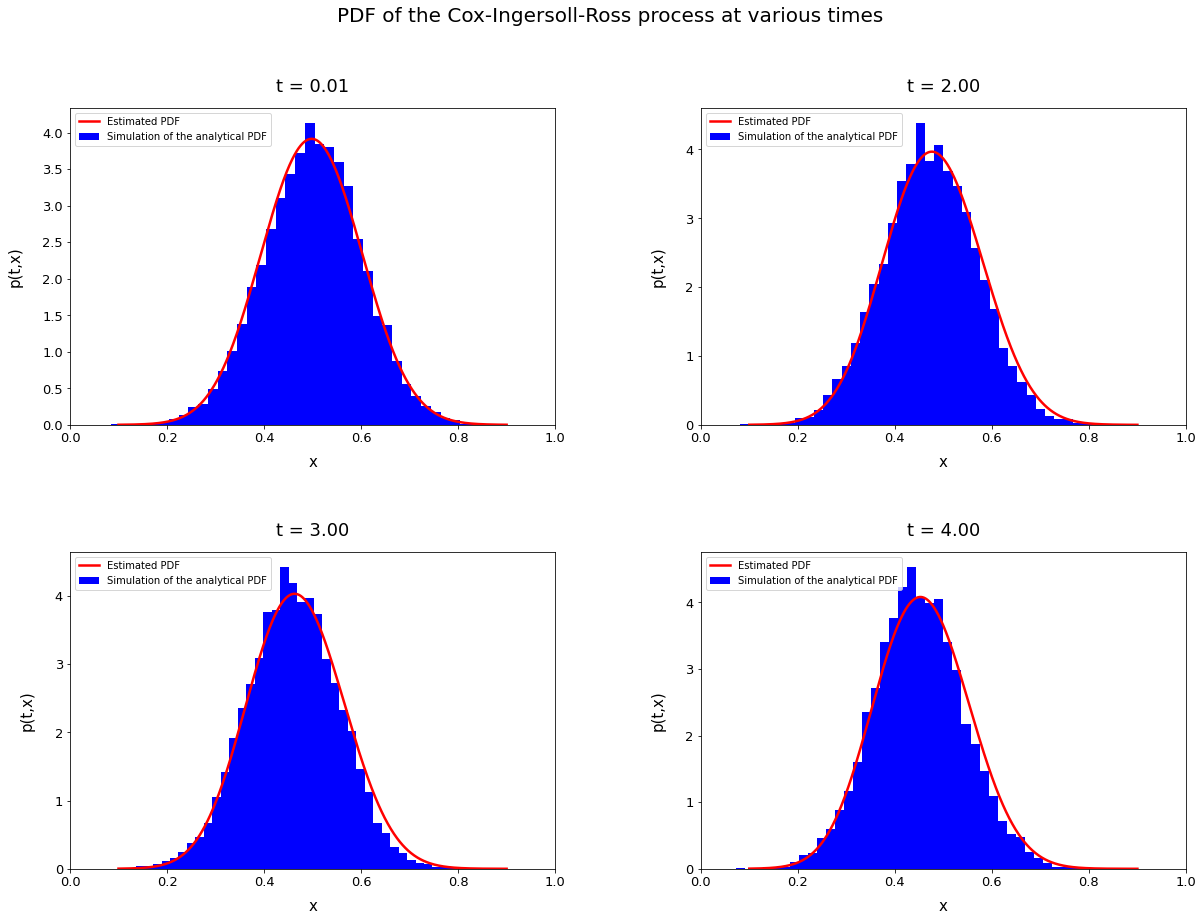

In [40]:
plt.figure()
plt.figure(figsize = (20,14))

# time values at which to examine density
densityTimes = [0+1e-2, 2, 3, 4]

# vector of x values for plotting 
x_plot = np.linspace(Xlow*x_multiplier, Xhigh*x_multiplier, 1000)

for i, curr_t in enumerate(densityTimes):
    
    # specify subplot
    plt.subplot(2,2,i+1)
    
    # simulate process at current t 
    sim_x = simulateCIR_GaussianStart(alpha, beta, theta, kappa, sigma, 10000, curr_t)
    
    # compute normalized density at all x values to plot and current t value
    t_plot = curr_t * np.ones_like(x_plot.reshape(-1,1))
    unnorm_dens = sess.run([p_unnorm], feed_dict= {t_tnsr:t_plot, x_interior_tnsr:x_plot.reshape(-1,1)})
    density = unnorm_dens[0] / sp.integrate.simps(unnorm_dens[0].reshape(x_plot.shape), x_plot)
    
    # plot histogram of simulated process values and overlay estimated density
    plt.hist(sim_x, bins=40, density=True, color = 'b',label="Simulation of the analytical PDF")
    plt.plot(x_plot, density, 'r', linewidth=2.5, label="Estimated PDF")
    
    # subplot options
    #plt.ylim(ymin=0.0, ymax=0.45)
    plt.xlim(xmin=0,xmax=1)
    plt.xlabel(r"x", fontsize=15, labelpad=10)
    plt.ylabel(r"p(t,x)", fontsize=15, labelpad=20)
    plt.title(r"t = %.2f"%(curr_t), fontsize=18, y=1.03)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.legend(loc="upper left")
# adjust space between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.suptitle("PDF of the Cox-Ingersoll-Ross process at various times", fontsize=20)

if saveFigure:
    plt.savefig(figureName)